# Project: Binary Classification

*By Daniel Deutsch, José Lucas Barretto, Kevin kühl and Lucas Miguel Agrizzi*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kerastuner.tuners import RandomSearch
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import History, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Loading the data

In [3]:
ants = np.load("./datasets/G_32_ant.npy")
grapes = np.load("./datasets/G_32_grapes.npy")

# Examining data samples

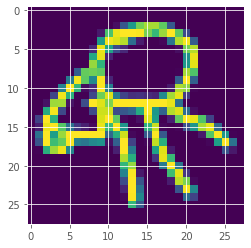

In [4]:
example_ant = np.reshape(ants[0], (28, 28))
plt.imshow(example_ant)
plt.show()

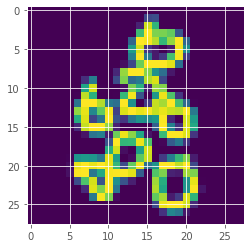

In [5]:
example_grape = np.reshape(grapes[0], (28, 28))
plt.imshow(example_grape)
plt.show()

# Building train and validation sets

In [6]:
# Creates the labels array
labels_ants = np.full(len(ants), 1, dtype=int)
labels_grapes = np.full(len(grapes), 0, dtype=int) 
labels = np.concatenate((labels_ants, labels_grapes), axis=0)

# Concatenates both datasets
data = np.concatenate((ants, grapes), axis=0)

# Splits the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [7]:
# Obtains scailing params
mean = np.mean(X_train)
std = np.std(X_train) + 1e-7

# Scales the training and test samples
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# First Approach - Neural Network with Random Hyperparameter Tuning

In [8]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(700, input_dim=784, activation='relu'))
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=300,
                                            max_value=800,
                                            step=1),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.SGD(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model


In [9]:
tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=20,
    executions_per_trial=1,
    project_name="keras_tuner"
)

INFO:tensorflow:Reloading Oracle from existing project .\keras_tuner\oracle.json
INFO:tensorflow:Reloading Tuner from .\keras_tuner\tuner0.json


In [10]:
tuner.search(X_train, y_train,
             epochs=10,
             batch_size=10,
             validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [11]:
best_model = tuner.get_best_models(num_models=1)[0]

In [12]:
history = History()
epochs = 10

history = best_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), validation_freq=1, batch_size=10, verbose=1)

Epoch 1/10
160/160 [==============================] - 2s 7ms/step - loss: 0.0153 - accuracy: 0.9994 - val_loss: 0.4546 - val_accuracy: 0.8650
Epoch 2/10
160/160 [==============================] - 1s 5ms/step - loss: 0.0108 - accuracy: 0.9994 - val_loss: 0.4748 - val_accuracy: 0.8600
Epoch 3/10
160/160 [==============================] - 1s 6ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.4692 - val_accuracy: 0.8725
Epoch 4/10
160/160 [==============================] - 1s 6ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.4923 - val_accuracy: 0.8550
Epoch 5/10
160/160 [==============================] - 1s 5ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.4917 - val_accuracy: 0.8650
Epoch 6/10
160/160 [==============================] - 1s 6ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.5172 - val_accuracy: 0.8625
Epoch 7/10
160/160 [==============================] - 1s 5ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.5244 - val_accuracy: 0.8650
Epoch 

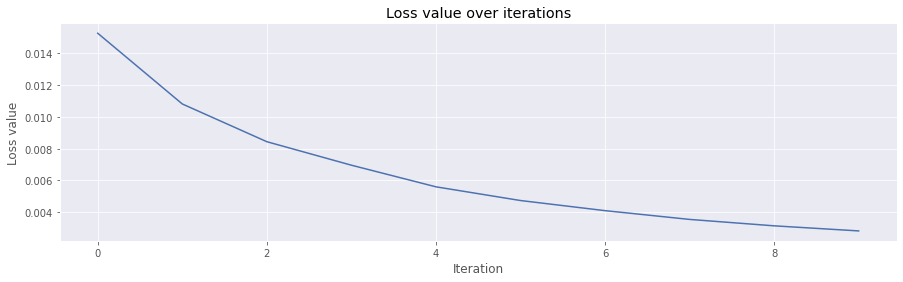

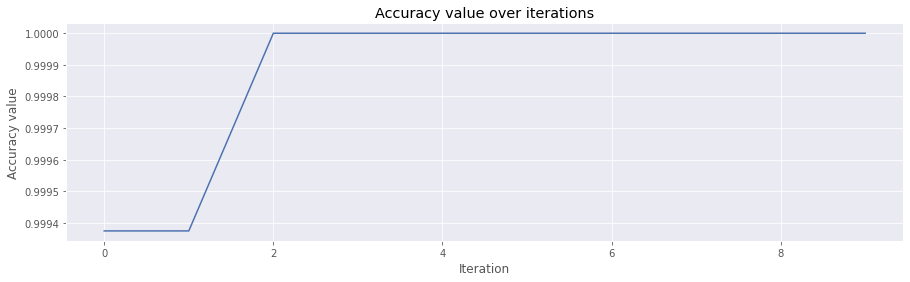

In [13]:
plt.plot(np.arange(len(history.history["loss"])), history.history["loss"])
plt.title("Loss value over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show()

plt.plot(np.arange(len(history.history["accuracy"])), history.history["accuracy"])
plt.title("Accuracy value over iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy value")
plt.show()

# Second Approach - SVM with GridSearch Hyperparameters tuning

In [14]:
# Sets the parameters for the grid search
params = {
    'kernel': ['linear', 'rbf'], 
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

# Performs a grid search with cross validation
clf = GridSearchCV(svm.SVC(), params, n_jobs=-1)
clf.fit(X_train, y_train)

# Fits the training data
clf.fit(X_train, y_train)

# Prints thee best params of the model
print(clf.best_params_)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [15]:
grid_predictions = clf.predict(X_test)
  
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       201
           1       0.85      0.89      0.87       199

    accuracy                           0.86       400
   macro avg       0.87      0.87      0.86       400
weighted avg       0.87      0.86      0.86       400



In [16]:
grid_predictions = clf.predict(X_train)
  
print(classification_report(y_train, grid_predictions))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       799
           1       0.93      0.94      0.93       801

    accuracy                           0.93      1600
   macro avg       0.93      0.93      0.93      1600
weighted avg       0.93      0.93      0.93      1600



# Approaches' comparison

For the Neural Network approach we achieved perfection on the training set and a good accuracy on the validation set (close to 85%).

On the SVM approach we were able to achieve 93% accuracy on training set and 86% on the validation set.

Both models are propense to overfitting, but we took measures to mitigate the risk. This is evident from the small difference between accuracies from training and validation sets. This measures involve the use of cross validation and the monitoring of validation set accuracy.